# TASK 3 : Customer Segmentation / Clustering

**Import necessary libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

**File paths**

In [2]:
customer_file = '/kaggle/input/dataset3/Customers.csv'
product_file = '/kaggle/input/dataset3/Products.csv'
transaction_file = '/kaggle/input/dataset3/Transactions.csv'

**Load datasets**

In [3]:
customers = pd.read_csv(customer_file)
products = pd.read_csv(product_file)
transactions = pd.read_csv(transaction_file)

**Merge datasets**

In [4]:
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

**Feature engineering for clustering**

In [5]:
agg_dict = {
    'Price': 'mean' if 'Price' in merged_data.columns else None,
    'Quantity': 'sum' if 'Quantity' in merged_data.columns else None,
    'TotalValue': 'sum' if 'TotalValue' in merged_data.columns else None,
}
agg_dict = {key: value for key, value in agg_dict.items() if value}

if not agg_dict:
    raise ValueError("No valid columns available for clustering.")

customer_features = merged_data.groupby('CustomerID').agg(agg_dict).reset_index()

**Ensure 'CustomerID' is in customer_features**

In [6]:
if 'CustomerID' not in customer_features.columns:
    raise KeyError("'CustomerID' column is missing in customer_features.")

**One-hot encode categorical variables (e.g., Region, Category)**

In [7]:
if 'Region' in customers.columns:
    customers = pd.get_dummies(customers, columns=['Region'], prefix='Region')
if 'Category' in products.columns:
    merged_data = pd.get_dummies(merged_data, columns=['Category'], prefix='Category')

**Combine customer and transaction features**

In [8]:
customer_features = customer_features.merge(customers, on='CustomerID', how='left')

**Keep only numeric columns for clustering**

In [9]:
numeric_features = customer_features.select_dtypes(include=['number'])
if 'CustomerID' in numeric_features.columns:
    numeric_features = numeric_features.drop(['CustomerID'], axis=1)

**Scale numeric features**

In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

**Determine optimal number of clusters using Davies-Bouldin Index**

In [11]:
db_scores = []
for k in range(2, 11):  # Evaluate for clusters between 2 and 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, clusters)
    db_scores.append((k, db_index))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

**Plot DB Index**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


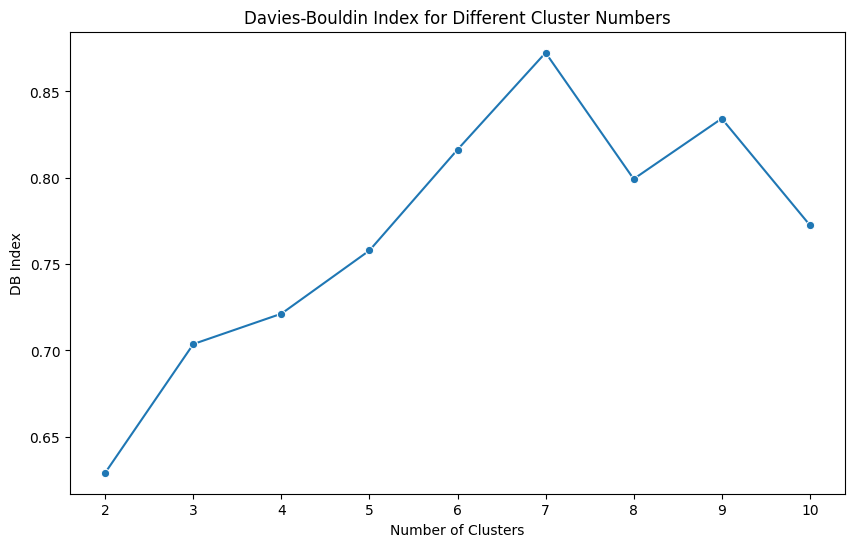

In [12]:
db_df = pd.DataFrame(db_scores, columns=['Number of Clusters', 'DB Index'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=db_df, x='Number of Clusters', y='DB Index', marker='o')
plt.title('Davies-Bouldin Index for Different Cluster Numbers')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

**Perform clustering with optimal number of clusters (choose the k with lowest DB Index)**

In [13]:
optimal_k = min(db_scores, key=lambda x: x[1])[0]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Visualize clusters using PCA**

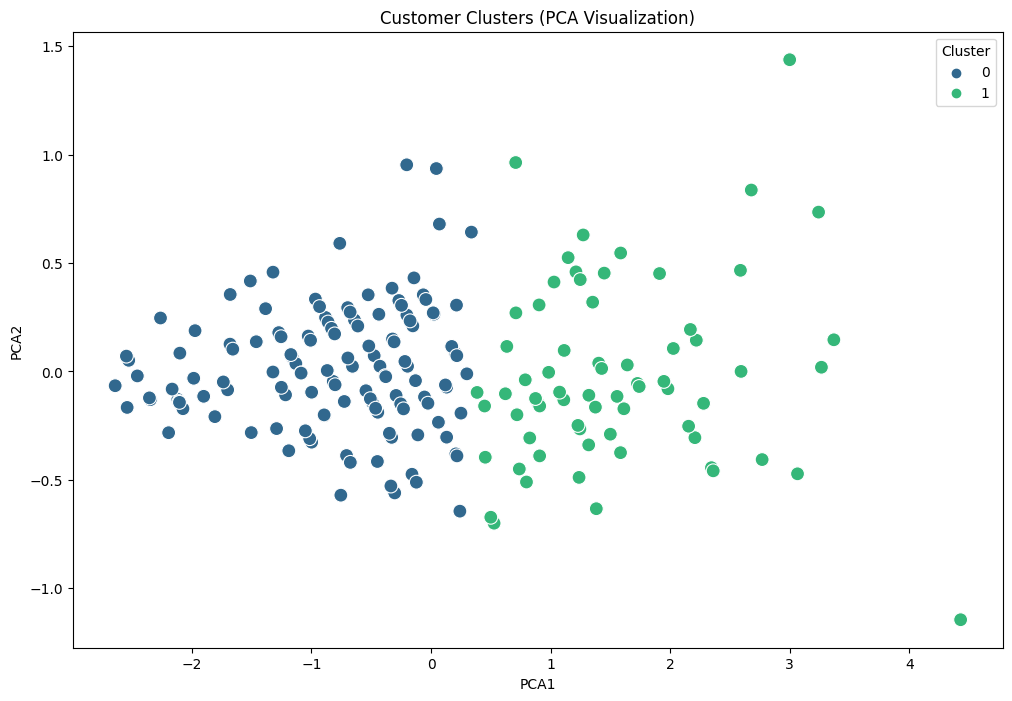

In [14]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
customer_features['PCA1'] = pca_features[:, 0]
customer_features['PCA2'] = pca_features[:, 1] 
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=customer_features,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    s=100,
)
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

**Save clustering results**

In [15]:
output_file = 'Shruti_Narwat_Clustering.csv'  # Replace with your name
customer_features[['CustomerID', 'Cluster']].to_csv(output_file, index=False)

print(f"Clustering results saved as '{output_file}'.")
print(f"Optimal Number of Clusters: {optimal_k}")

Clustering results saved as 'Shruti_Narwat_Clustering.csv'.
Optimal Number of Clusters: 2
